In [1]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset, ClassLabel
from sklearn.preprocessing import MultiLabelBinarizer
#Seeding for deterministic results
RANDOM_SEED = 64
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

if torch.cuda.is_available():
   torch.cuda.manual_seed(RANDOM_SEED)
   torch.cuda.manual_seed_all(RANDOM_SEED) 
   torch.backends.cudnn.deterministic = True  
   torch.backends.cudnn.benchmark = False

/home/njfernandez/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
comfunctions_basic = 'comfunct_basic.txt'
df = pd.read_csv(comfunctions_basic, delimiter=";")
df = df[df['function'].isin(['ANGRY', 'DISAGREE', 'DISAPPOINTED', 'DISLIKE', 'NOT_APPROVE',
       'NOT_CORRECT', 'OTHER', 'PESSIMISTIC', 'WORRIED'])].rename(columns={"function": "functions"})


In [3]:
unique_labels = df["functions"].unique().tolist()
function_labels = ClassLabel(names=unique_labels)

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit([function_labels.names])
labels_classes = mlb.classes_
labels_classes

array(['ANGRY', 'DISAGREE', 'DISAPPOINTED', 'DISLIKE', 'NOT_APPROVE',
       'NOT_CORRECT', 'OTHER', 'PESSIMISTIC', 'WORRIED'], dtype=object)

In [4]:
model_ckpt = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):   
    token_embeddings = model_output[0] 
    input_mask_expanded = (attention_mask
                           .unsqueeze(-1)
                           .expand(token_embeddings.size())
                           .float()) 
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9) 
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                       return_tensors="pt")
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

from sentence_transformers import util
def cosine_sim(batch):
    batch['predicted_labels'], batch['scores'] = [[] for _ in range(len(batch['text']))], [[] for _ in range(len(batch['text']))]
    for i, emb in enumerate(batch['embedding']):
        scores = {func: util.pytorch_cos_sim(emb, metaemb[func]).item() for func in metaemb}
        sorted_labels = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        sorted_labels, sorted_scores = zip(*sorted_labels)
        batch['predicted_labels'][i] = sorted_labels
        batch['scores'][i] = sorted_scores        
    return batch

In [5]:
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either `threshold` or `topk`.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

from sklearn.metrics import classification_report
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0, 
        output_dict=True)

In [6]:
function_mapping = {'OTHER': ['admiration', 'approval', 'gratitude', 'amusement', 'curiosity', 'embarrassment', 'love', 'optimism', 'joy', 
                              'realization', 'confusion', 'caring', 'excitement', 'surprise', 'desire', 'pride', 'relief', 'neutral'], 
           'NOT_INTERESTED': [''], 
           'DISLIKE':['disgust', 'annoyance'], 
           'NOT_CORRECT': ['disapproval'], 
           'PESSIMISTIC':['grief', 'remorse', 'sadness'], 
           'WORRIED':['fear', 'nervousness'], 
           'ANGRY': ['anger'], 
           'DISAPPOINTED': ['disappointment'], 
           'BORED': [''], 
           'NOT_APPROVE':['disapproval'], 
           'NOT_IMPORTANT': [''], 
           'DISAGREE': ['disapproval'], 
           'WARN': [''], 
           'COMPLAIN': [''], 
           'THREATEN': [''], 
           'UNWILLING': [''], 
           'DISTRUST' : [''],
           'REFUSE': [''] }

mapping = {
    0:"admiration",
    1:"amusement",
    2:"anger",
    3:"annoyance",
    4:"approval",
    5:"caring",
    6:"confusion",
    7:"curiosity",
    8:"desire",
    9:"disappointment",
    10:"disapproval",
    11:"disgust",
    12:"embarrassment",
    13:"excitement",
    14:"fear",
    15:"gratitude",
    16:"grief",
    17:"joy",
    18:"love",
    19:"nervousness",
    20:"optimism",
    21:"pride",
    22:"realization",
    23:"relief",
    24:"remorse",
    25:"sadness",
    26:"surprise",
    27:"neutral",
}

go_emotions = load_dataset("go_emotions").remove_columns("id")
def adjust_labels(batch):
    batch['emotions'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["labels"]):
        batch["emotions"][i] = [mapping[label] for label in batch["labels"][i]]
    return batch

go_emotions = go_emotions.map(adjust_labels, batched=True)
def map_labels(batch):
    batch['functions'] = [[] for _ in range(len(batch['text']))]
    for i, item in enumerate(batch["emotions"]):
        batch["functions"][i] = [key for key,value in function_mapping.items() if any(emotion in batch["emotions"][i] for emotion in value)]
    return batch
go_emotions = go_emotions.map(map_labels, batched=True).remove_columns("labels")

# Convert labels to one hot enconding vectors
def one_hot_encoding(batch):
    label_ids = mlb.transform(batch['functions'])
    return {"label_ids":label_ids}
go_emotions = go_emotions.map(one_hot_encoding, batched=True)

No config specified, defaulting to: go_emotions/simplified
Found cached dataset go_emotions (/home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d)
100%|██████████| 3/3 [00:00<00:00, 594.77it/s]
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-1c4d70c4ecc5a4bd.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-8f90b5d8ac946ce8.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-f0dc721270e34384.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified

# Function basic experiment

In [7]:
df["functions"] = df["functions"].apply(lambda x: [x])

In [8]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df.reset_index(drop=True)),
     "test": go_emotions['test']
}
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'functions'],
        num_rows: 629
    })
    test: Dataset({
        features: ['text', 'emotions', 'functions', 'label_ids'],
        num_rows: 5427
    })
})

In [9]:
dataset = dataset.map(embed_text, batched=True, batch_size=16)

100%|██████████| 40/40 [00:02<00:00, 19.21ba/s]
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-2f799856ab66eecd.arrow


In [10]:
metaemb = {}

for i, functions in enumerate(dataset['train']['functions']):
    emb = torch.FloatTensor(dataset['train']['embedding'][i])
    for function in functions:
        if function not in metaemb:
            metaemb[function] = []
        
        metaemb[function].append(emb)

for key, value in metaemb.items():
    metaemb[key] = torch.stack(value)
    metaemb[key] = torch.mean(metaemb[key], dim=0)

print(metaemb.keys())

dict_keys(['DISLIKE', 'NOT_CORRECT', 'PESSIMISTIC', 'WORRIED', 'ANGRY', 'DISAPPOINTED', 'NOT_APPROVE', 'DISAGREE', 'OTHER'])


In [11]:
metaemb['DISLIKE']

tensor([ 6.7538e-02,  1.3335e-01, -1.2454e-02, -2.7410e-02, -2.4313e-02,
         1.7517e-01,  4.0530e-02, -5.4710e-02,  2.2016e-02,  2.7840e-02,
        -5.9152e-03, -1.0522e-02, -7.8893e-02, -9.0480e-02, -1.2743e-01,
        -2.1452e-02, -9.0511e-03,  1.0107e-01,  1.2335e-01, -7.9975e-02,
        -1.4674e-02,  4.6716e-02,  7.9325e-02, -2.5987e-02,  5.6430e-03,
        -1.1473e-01,  1.3531e-01,  2.3348e-02,  4.1154e-02,  5.0528e-03,
         2.1741e-01, -2.6105e-02, -1.9900e-01,  2.0155e-02,  1.0432e-01,
         9.0955e-02,  5.0205e-02,  9.6020e-02, -2.6545e-02,  1.4623e-01,
         2.6646e-01,  8.5687e-02,  3.6279e-02,  5.9509e-02, -3.4850e-02,
        -7.4105e-02,  1.0791e-01,  3.3522e-02,  7.1783e-02, -7.7260e-02,
         6.4752e-02,  1.6176e-01, -1.8496e-01,  2.1648e-02,  1.4033e-01,
         8.0908e-02, -1.2508e-01, -1.7596e-02,  6.5109e-02, -9.4208e-02,
        -1.1379e-01, -6.1426e-02, -1.4919e-01,  2.1703e-02,  1.0802e-03,
         6.5309e-02,  7.3510e-02, -1.5441e-01,  1.2

In [12]:
dataset['test'] = dataset['test'].map(cosine_sim, batched=True, batch_size=16)

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-e4ddff36a7e2d00a.arrow


In [13]:
dataset['test'][0]

{'text': 'I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!',
 'emotions': ['sadness'],
 'functions': ['PESSIMISTIC'],
 'label_ids': [0, 0, 0, 0, 0, 0, 0, 1, 0],
 'embedding': [0.008581333793699741,
  0.14656728506088257,
  -0.013212994672358036,
  0.09964169561862946,
  0.2041880339384079,
  0.1726440191268921,
  -0.05481830611824989,
  -0.0032580289989709854,
  0.023485802114009857,
  0.0623701848089695,
  -0.00784754753112793,
  0.12641432881355286,
  0.0007641988922841847,
  -0.22838029265403748,
  -0.11994113028049469,
  -0.1672920286655426,
  -0.0005084783770143986,
  0.0983646959066391,
  0.09415677934885025,
  0.04176487401127815,
  0.09891771525144577,
  0.0651787519454956,
  0.18468163907527924,
  -0.07021557539701462,
  -0.12380088120698929,
  -0.06982182711362839,
  0.1068418025970459,
  0.08221223950386047,
  0.09240254759788513,
  0.021407078951597214,
  0.24869926273822784,
  0.01290543656796217,
  -0.1332826465368271,
  

In [14]:
macros, micros, macroprecision, macrorecall = [], [], [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    dataset['test'] = dataset['test'].map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(dataset['test'])
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])
    macroprecision.append(clf_report['macro avg']['precision'])
    macrorecall.append(clf_report['macro avg']['recall'])

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-d3721c2f7d15a38f.arrow
100%|██████████| 5427/5427 [00:01<00:00, 5248.34ex/s]


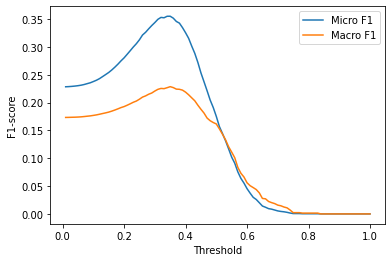

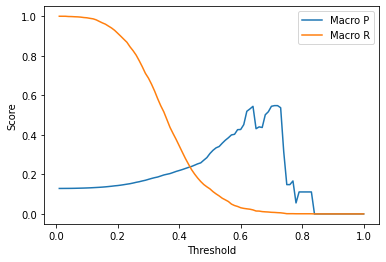

In [15]:
import matplotlib.pyplot as plt

plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()
plt.plot(thresholds, macroprecision, label="Macro P")
plt.plot(thresholds, macrorecall, label="Macro R")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [16]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

Best threshold (micro): 0.35000000000000003 with F1-score 0.36.
Best threshold (macro): 0.35000000000000003 with F1-score 0.23.
Best threshold (macro-Precision): 0.7100000000000001 with macroP-score 0.55.
Best threshold (macro-Recall): 0.01 with macroR-score 1.00.


In [17]:
dataset['test'] = dataset['test'].map(get_preds, fn_kwargs={'threshold': 0.35})
clf_report = get_clf_report(dataset['test'])

100%|██████████| 5427/5427 [00:01<00:00, 4739.94ex/s]


In [18]:
print(clf_report)

{'ANGRY': {'precision': 0.0995850622406639, 'recall': 0.6060606060606061, 'f1-score': 0.17106200997861723, 'support': 198}, 'DISAGREE': {'precision': 0.10853199498117942, 'recall': 0.6479400749063671, 'f1-score': 0.18592154755507792, 'support': 267}, 'DISAPPOINTED': {'precision': 0.08431163287086446, 'recall': 0.5231788079470199, 'f1-score': 0.14522058823529413, 'support': 151}, 'DISLIKE': {'precision': 0.1903584672435105, 'recall': 0.358974358974359, 'f1-score': 0.24878836833602586, 'support': 429}, 'NOT_APPROVE': {'precision': 0.13789473684210526, 'recall': 0.49063670411985016, 'f1-score': 0.2152834839769926, 'support': 267}, 'NOT_CORRECT': {'precision': 0.11147811725846409, 'recall': 0.5056179775280899, 'f1-score': 0.18267929634641406, 'support': 267}, 'OTHER': {'precision': 0.8701942951632906, 'recall': 0.4799361605107159, 'f1-score': 0.6186627479794268, 'support': 4386}, 'PESSIMISTIC': {'precision': 0.07495069033530571, 'recall': 0.3584905660377358, 'f1-score': 0.12398042414355627

In [19]:
import pandas as pd

df = pd.DataFrame(clf_report).transpose()
with open(r'classification_report_functions_basic_goemotions_metaembedding.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

In [20]:
def get_predicted_labels(batch):
    tranformed_into_label_names = mlb.inverse_transform(np.array(batch['pred_label_ids']))
    batch['predicted_labels'] = list(map(list, tranformed_into_label_names))
    return batch
dataset['test'] = dataset['test'].map(get_predicted_labels, batched=True)

dataset['test'].set_format("pandas")
cols = ["text", "emotions", "functions", "predicted_labels"]
df_test = dataset['test'][:][cols]
df_test.to_csv('preds_functions_basic_goemotions_metaembedding.tsv',header =True, sep = '\t',index=False)

100%|██████████| 6/6 [00:00<00:00, 91.60ba/s]


In [21]:
df_test

,text,emotions,functions,predicted_labels
0,I’m really sorry about your situation :( Altho...,[sadness],[PESSIMISTIC],"[ANGRY, DISAPPOINTED, OTHER]"
1,It's wonderful because it's awful. At not with.,[admiration],[OTHER],"[ANGRY, DISAGREE, DISAPPOINTED, DISLIKE, NOT_A..."
2,"Kings fan here, good luck to you guys! Will be...",[excitement],[OTHER],[OTHER]
3,"I didn't know that, thank you for teaching me ...",[gratitude],[OTHER],"[DISAGREE, NOT_CORRECT, OTHER]"
4,They got bored from haunting earth for thousan...,[neutral],[OTHER],[]
...,...,...,...,...
5422,Thanks. I was diagnosed with BP 1 after the ho...,[gratitude],[OTHER],[]
5423,Well that makes sense.,[approval],[OTHER],"[DISAGREE, NOT_CORRECT, OTHER]"
5424,Daddy issues [NAME],[neutral],[OTHER],[]
5425,So glad I discovered that subreddit a couple m...,[admiration],[OTHER],[OTHER]


# Function extended experiment

In [22]:
comfunctions_extended = 'comfunct_extended.txt'
df = pd.read_csv(comfunctions_extended, delimiter=";")
df = df[df['function'].isin(['ANGRY', 'DISAGREE', 'DISAPPOINTED', 'DISLIKE', 'NOT_APPROVE',
       'NOT_CORRECT', 'OTHER', 'PESSIMISTIC', 'WORRIED'])].rename(columns={"function": "functions"})
df["functions"] = df["functions"].apply(lambda x: [x])
df

,text,functions
0,"Hey #friends, just wanted to clarify that the ...",[OTHER]
1,Good morning everyone! ☀️ Just wanted to say a...,[OTHER]
2,"Hey #team, don't forget our meeting at 2pm tod...",[OTHER]
3,"Sorry for the late reply, I was swamped at wor...",[OTHER]
4,"Hey, can someone introduce me to @jane_doe? I'...",[OTHER]
...,...,...
2106,i hate this,[DISLIKE]
2107,this is the worst,[DISLIKE]
2108,"Ew, spinach in my salad again. 😒 #NotAVegHead",[DISLIKE]
2109,🤢 Don't like this new food trend 🍔 #StickToThe...,[DISLIKE]


In [23]:
dataset = DatasetDict({
    "train": Dataset.from_pandas(df.reset_index(drop=True)),
     "test": go_emotions['test']
}
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'functions'],
        num_rows: 1264
    })
    test: Dataset({
        features: ['text', 'emotions', 'functions', 'label_ids'],
        num_rows: 5427
    })
})

In [24]:
dataset = dataset.map(embed_text, batched=True, batch_size=16)

100%|██████████| 79/79 [00:08<00:00,  9.29ba/s]
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-2f799856ab66eecd.arrow


In [25]:
metaemb = {}

for i, functions in enumerate(dataset['train']['functions']):
    emb = torch.FloatTensor(dataset['train']['embedding'][i])
    for function in functions:
        if function not in metaemb:
            metaemb[function] = []
        
        metaemb[function].append(emb)

for key, value in metaemb.items():
    metaemb[key] = torch.stack(value)
    metaemb[key] = torch.mean(metaemb[key], dim=0)

print(metaemb.keys())

dict_keys(['OTHER', 'DISAGREE', 'NOT_APPROVE', 'DISAPPOINTED', 'ANGRY', 'WORRIED', 'PESSIMISTIC', 'NOT_CORRECT', 'DISLIKE'])


In [26]:
dataset['test'] = dataset['test'].map(cosine_sim, batched=True, batch_size=16)

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-1302e648c0020a3d.arrow


In [27]:
dataset['test'] 

Dataset({
    features: ['text', 'emotions', 'functions', 'label_ids', 'embedding', 'predicted_labels', 'scores'],
    num_rows: 5427
})

In [28]:
macros, micros, macroprecision, macrorecall = [], [], [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    dataset['test'] = dataset['test'].map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(dataset['test'])
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])
    macroprecision.append(clf_report['macro avg']['precision'])
    macrorecall.append(clf_report['macro avg']['recall'])

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-fac38236136c0ed1.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-3c03fdc913bc5299.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-cff6069cb4d94777.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-4b7324e52143a6ea.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cach

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-1ae04ea9d792a9ca.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-e9ea4add843ceb1f.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-ffac966a1ef6b235.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-2d1e6f9e44329167.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cach

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-59015ce86f30833c.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-398a70c1f92cc1dd.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-0a78fbbc27eb379d.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-f50c6905fc968e7b.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cach

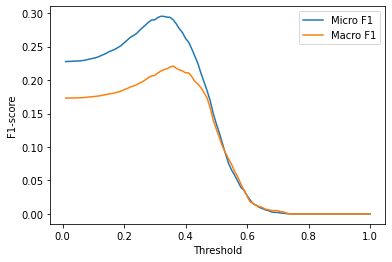

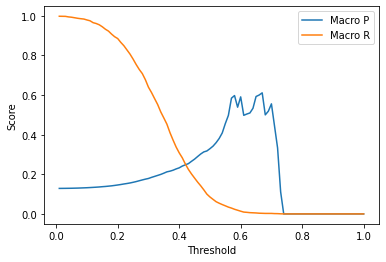

In [29]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()
plt.plot(thresholds, macroprecision, label="Macro P")
plt.plot(thresholds, macrorecall, label="Macro R")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [30]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

Best threshold (micro): 0.32 with F1-score 0.30.
Best threshold (macro): 0.36000000000000004 with F1-score 0.22.
Best threshold (macro-Precision): 0.67 with macroP-score 0.61.
Best threshold (macro-Recall): 0.01 with macroR-score 1.00.


In [31]:
dataset['test'] = dataset['test'].map(get_preds, fn_kwargs={'threshold': 0.35})
clf_report = get_clf_report(dataset['test'])

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-2ab3353de757ec32.arrow


In [32]:
print(clf_report)

{'ANGRY': {'precision': 0.10469314079422383, 'recall': 0.5858585858585859, 'f1-score': 0.1776416539050536, 'support': 198}, 'DISAGREE': {'precision': 0.1334569045412419, 'recall': 0.5393258426966292, 'f1-score': 0.2139673105497771, 'support': 267}, 'DISAPPOINTED': {'precision': 0.06428571428571428, 'recall': 0.41721854304635764, 'f1-score': 0.11140583554376657, 'support': 151}, 'DISLIKE': {'precision': 0.20085836909871244, 'recall': 0.5454545454545454, 'f1-score': 0.2936010037641154, 'support': 429}, 'NOT_APPROVE': {'precision': 0.11887477313974591, 'recall': 0.49063670411985016, 'f1-score': 0.19138056975894813, 'support': 267}, 'NOT_CORRECT': {'precision': 0.07931034482758621, 'recall': 0.5168539325842697, 'f1-score': 0.1375186846038864, 'support': 267}, 'OTHER': {'precision': 0.9169909208819714, 'recall': 0.3223894208846329, 'f1-score': 0.47705802968960864, 'support': 4386}, 'PESSIMISTIC': {'precision': 0.11461988304093568, 'recall': 0.46226415094339623, 'f1-score': 0.183692596063730

In [33]:
df = pd.DataFrame(clf_report).transpose()
with open(r'classification_report_functions_extended_goemotions_metaembedding.csv', 'w') as csv_file:
    df.to_csv(path_or_buf=csv_file)

In [34]:
dataset['test'] = dataset['test'].map(get_predicted_labels, batched=True)

dataset['test'].set_format("pandas")
cols = ["text", "emotions", "functions", "predicted_labels"]
df_test = dataset['test'][:][cols]
df_test.to_csv('preds_functions_extended_goemotions_metaembedding.tsv',header =True, sep = '\t',index=False)

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-8d663a97af185c7e.arrow


# GoEmotions train (baseline) experiment

In [35]:
dataset = DatasetDict({
    "train": go_emotions['train'],
     "test": go_emotions['test']
}
    )
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'emotions', 'functions', 'label_ids'],
        num_rows: 43410
    })
    test: Dataset({
        features: ['text', 'emotions', 'functions', 'label_ids'],
        num_rows: 5427
    })
})

In [36]:
dataset = dataset.map(embed_text, batched=True, batch_size=16)

Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-9dba80978830b9ec.arrow
Loading cached processed dataset at /home/njfernandez/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/2637cfdd4e64d30249c3ed2150fa2b9d279766bfcd6a809b9f085c61a90d776d/cache-2f799856ab66eecd.arrow


In [ ]:
metaemb = {}

for i, functions in enumerate(dataset['train']['functions']):
    emb = torch.FloatTensor(dataset['train']['embedding'][i])
    for function in functions:
        if function not in metaemb:
            metaemb[function] = []
        
        metaemb[function].append(emb)

for key, value in metaemb.items():
    metaemb[key] = torch.stack(value)
    metaemb[key] = torch.mean(metaemb[key], dim=0)

print(metaemb.keys())

In [ ]:
dataset['test'] = dataset['test'].map(cosine_sim, batched=True, batch_size=16)

In [43]:
macros, micros, macroprecision, macrorecall = [], [], [], []
thresholds = np.linspace(0.01, 1, 100)
for threshold in thresholds:
    dataset['test'] = dataset['test'].map(get_preds,
                                    fn_kwargs={"threshold": threshold})
    clf_report = get_clf_report(dataset['test'])
    micros.append(clf_report["micro avg"]["f1-score"])
    macros.append(clf_report["macro avg"]["f1-score"])
    macroprecision.append(clf_report['macro avg']['precision'])
    macrorecall.append(clf_report['macro avg']['recall'])

100%|██████████| 5427/5427 [00:00<00:00, 5498.79ex/s]


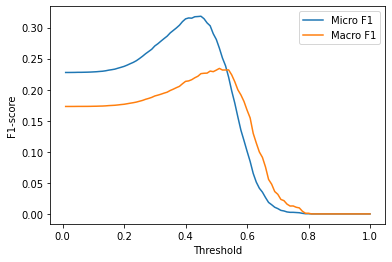

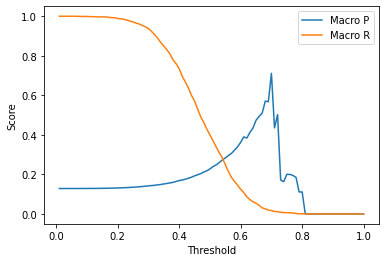

In [44]:
plt.plot(thresholds, micros, label="Micro F1")
plt.plot(thresholds, macros, label="Macro F1")
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()
plt.plot(thresholds, macroprecision, label="Macro P")
plt.plot(thresholds, macrorecall, label="Macro R")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

In [45]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}.')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}.')
best_t, best_macro_P = thresholds[np.argmax(macroprecision)], np.max(macroprecision)
print(f'Best threshold (macro-Precision): {best_t} with macroP-score {best_macro_P:.2f}.')
best_t, best_macro_R = thresholds[np.argmax(macrorecall)], np.max(macrorecall)
print(f'Best threshold (macro-Recall): {best_t} with macroR-score {best_macro_R:.2f}.')

Best threshold (micro): 0.45 with F1-score 0.32.
Best threshold (macro): 0.51 with F1-score 0.23.
Best threshold (macro-Precision): 0.7000000000000001 with macroP-score 0.71.
Best threshold (macro-Recall): 0.01 with macroR-score 1.00.


In [48]:
dataset['test'] = dataset['test'].map(get_preds, fn_kwargs={'threshold': 0.5})
clf_report = get_clf_report(dataset['test'])

100%|██████████| 5427/5427 [00:01<00:00, 5364.72ex/s]


In [49]:
print(clf_report)

{'ANGRY': {'precision': 0.08629707112970711, 'recall': 0.8333333333333334, 'f1-score': 0.15639810426540285, 'support': 198}, 'DISAGREE': {'precision': 0.09514656415185008, 'recall': 0.7415730337078652, 'f1-score': 0.1686541737649063, 'support': 267}, 'DISAPPOINTED': {'precision': 0.045271178843567905, 'recall': 0.6688741721854304, 'f1-score': 0.08480268681780016, 'support': 151}, 'DISLIKE': {'precision': 0.14584259670964872, 'recall': 0.7645687645687645, 'f1-score': 0.24495892457057503, 'support': 429}, 'NOT_APPROVE': {'precision': 0.09514656415185008, 'recall': 0.7415730337078652, 'f1-score': 0.1686541737649063, 'support': 267}, 'NOT_CORRECT': {'precision': 0.09514656415185008, 'recall': 0.7415730337078652, 'f1-score': 0.1686541737649063, 'support': 267}, 'OTHER': {'precision': 0.8230989500477252, 'recall': 0.5898312813497492, 'f1-score': 0.6872094567671669, 'support': 4386}, 'PESSIMISTIC': {'precision': 0.08455114822546973, 'recall': 0.7641509433962265, 'f1-score': 0.1522556390977443